In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
# image = cv2.imread('data/inpainting/input/01.png')

In [2]:
def increase_brightness(img, mask, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, (mask // 255) * value)
    v = np.clip(v, 0, 255)
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


In [3]:
def histogram_equalization(image):
    # Convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # Split the channels
    y, cr, cb = cv2.split(ycrcb)
    
    # Equalize the histogram of the Y channel
    y_eq = cv2.equalizeHist(y)
    
    # Merge the channels back
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    
    # Convert back to BGR color space
    image_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    
    return image_eq

# Method 2: CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    # Convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # Split the channels
    y, cr, cb = cv2.split(ycrcb)
    
    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    y_clahe = clahe.apply(y)
    
    # Merge the channels back
    ycrcb_clahe = cv2.merge((y_clahe, cr, cb))
    
    # Convert back to BGR color space
    image_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)
    
    return image_clahe

# Method 3: Manual Brightness and Contrast Adjustment
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    # The image should be in BGR format
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow
        image = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        image = cv2.addWeighted(image, alpha_c, image, 0, gamma_c)

    return image

# level like photoshop
def adjust_levels(image, in_levels=(0, 255), gamma=1.0, out_levels=(0, 255)):

    if image.dtype != np.float32:
        image = image.astype(np.float32)
    
    image = (image - in_levels[0]) / (in_levels[1] - in_levels[0])
    image = np.clip(image, 0, 1)  
    
    image = np.power(image, gamma)
    
    image = image * (out_levels[1] - out_levels[0]) + out_levels[0]
    image = np.clip(image, out_levels[0], out_levels[1])  
    
    if image.dtype == np.float32:
        image = np.clip(image, 0, 255).astype(np.uint8)
    
    return image


In [4]:
input_folder = 'data/inpainting/input'
output_folder = 'data/inpainting/output'

In [5]:
for filename in tqdm(os.listdir(input_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        image_path = os.path.join(input_folder, filename)

        image = cv2.imread(image_path)
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Create a mask where black pixels are 1 and others are 0
        _, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

        # Dilate the mask to cover more area
        kernel = np.ones((3, 3), np.uint8)
        # dilated_mask = cv2.dilate(mask, kernel, iterations=3)

        # Inpaint the black areas using a larger radius for better blending
        inpainted_image = image.copy()
        # for i in tqdm(range(6)):
        inpainted_image = cv2.inpaint(inpainted_image, mask, inpaintRadius=20, flags=cv2.INPAINT_TELEA)

        _, mask_2 = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
        # dilated_mask_2 = cv2.dilate(mask_2, kernel, iterations=6)
        # Increase the brightness of the masked area
        brightened_image = increase_brightness(inpainted_image, mask_2, 150)

        image_clahe = apply_clahe(brightened_image)
        
        # save the image
        cv2.imwrite(os.path.join(output_folder, filename), image_clahe)

100%|██████████| 18/18 [19:51<00:00, 66.19s/it]


In [15]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create a mask where black pixels are 1 and others are 0
_, mask = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV)

# Dilate the mask to cover more area
kernel = np.ones((3, 3), np.uint8)
# dilated_mask = cv2.dilate(mask, kernel, iterations=3)

# Inpaint the black areas using a larger radius for better blending
inpainted_image = image.copy()
# for i in tqdm(range(6)):
inpainted_image = cv2.inpaint(inpainted_image, mask, inpaintRadius=20, flags=cv2.INPAINT_TELEA)

_, mask_2 = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
# dilated_mask_2 = cv2.dilate(mask_2, kernel, iterations=6)
# Increase the brightness of the masked area
brightened_image = increase_brightness(inpainted_image, mask_2, 150)

image_clahe = apply_clahe(brightened_image)
# save the image

In [16]:
# _, mask_2 = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
# # dilated_mask_2 = cv2.dilate(mask_2, kernel, iterations=6)
# # Increase the brightness of the masked area
# brightened_image = increase_brightness(inpainted_image, mask_2, 150)

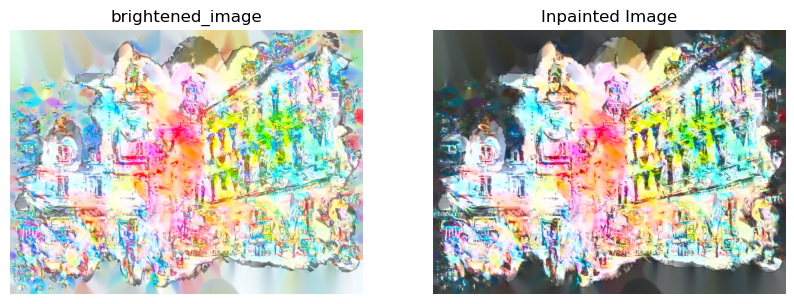

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('brightened_image')
plt.imshow(cv2.cvtColor(brightened_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
#axis
plt.axis('off')
plt.title('Inpainted Image')
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))

plt.show()

In [19]:
image_hist_eq = histogram_equalization(brightened_image)
image_clahe = apply_clahe(brightened_image)
image_brightness_contrast = adjust_brightness_contrast(brightened_image, brightness=1, contrast=50)
# min_max normalization to output iamge
image_minmax = cv2.normalize(brightened_image, None, 0, 255, cv2.NORM_MINMAX)


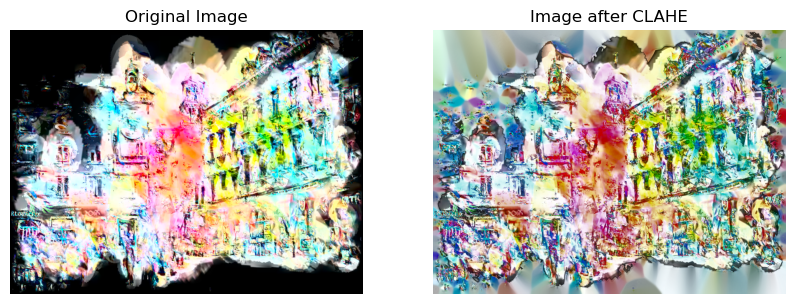

In [20]:
# show original image and the image after applying CLAHE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Image after CLAHE')
plt.imshow(cv2.cvtColor(image_clahe, cv2.COLOR_BGR2RGB))


In [21]:
# save image
cv2.imwrite('data/inpainting/output/01.png', image_clahe)

True